In [ ]:
!pip insyal

In [29]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer


In [30]:
# First lets load the transcript
with open('../quint/frontend/transcripts/podcast_transcript_paragraphed.txt') as f:
    doc = f.readlines()
    f.close()
data = [each.replace('\n', '').strip() for each in doc if each !='\n']

In [45]:
from bertopic import BERTopic

In [74]:
from bertopic import BERTopic

topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(data)

Batches: 100%|████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.38it/s]
2022-09-30 11:06:17,056 - BERTopic - Transformed documents to Embeddings
2022-09-30 11:06:21,420 - BERTopic - Reduced dimensionality
2022-09-30 11:06:21,442 - BERTopic - Clustered reduced embeddings


In [75]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,76,-1_the_of_and_to
1,0,63,0_the_of_and_to
2,1,56,1_the_of_and_to


In [32]:
# Loading a model - don't try it at home, it might take some time - it is 420 mb
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(data, show_progress_bar=True)
print(embeddings.shape)

Batches: 100%|████████████████████████████████████████████████████████████████████████████| 7/7 [00:27<00:00,  3.87s/it]

(195, 768)


In [92]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=3, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [93]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

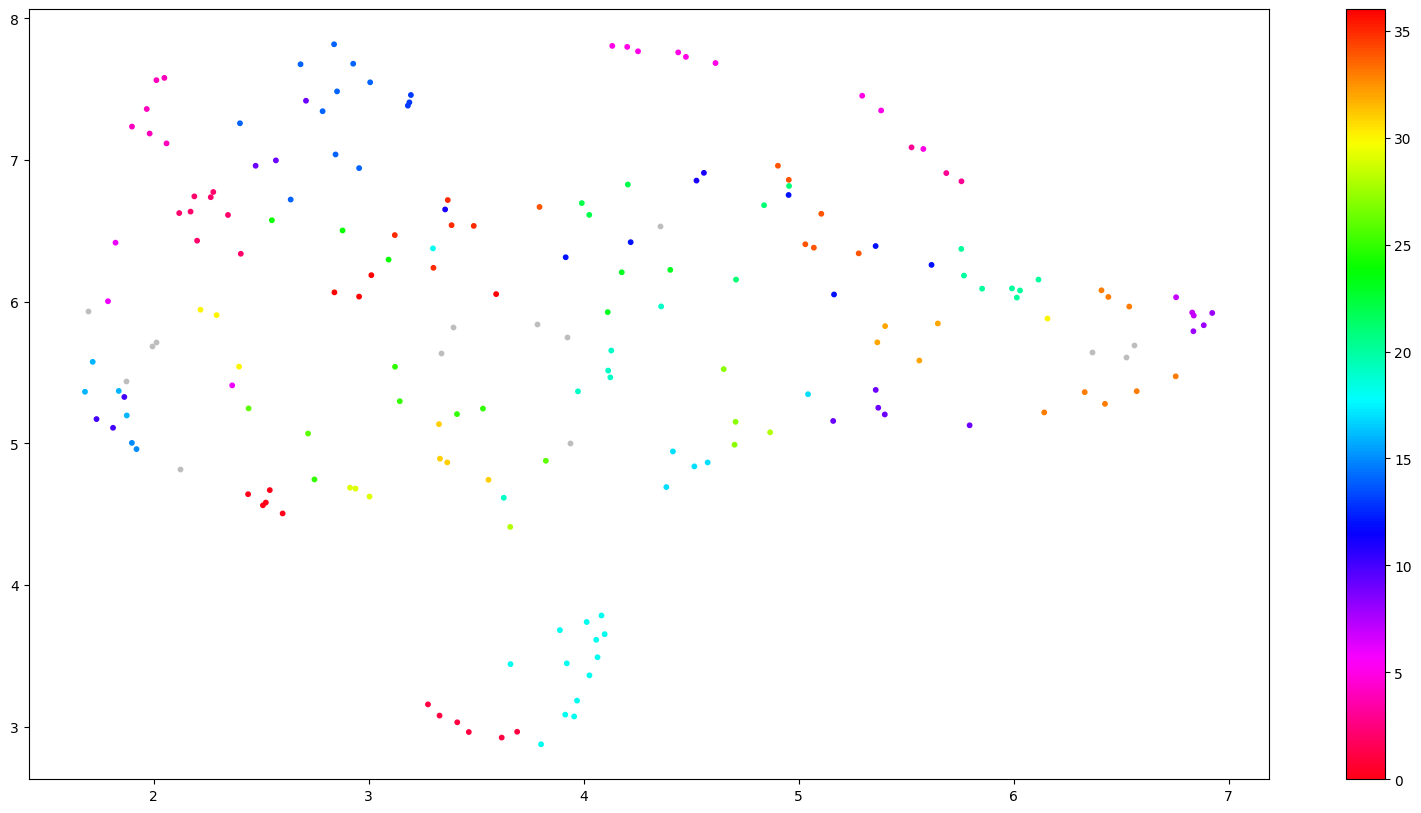

In [94]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
plt.colorbar()

In [95]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [96]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [97]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,14
19,18,14
15,14,10
6,5,9
34,33,8
3,2,8
10,9,8
35,34,7
21,20,7
2,1,6


In [98]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
17,16,21
9,8,16
12,11,15
15,14,14
0,-1,14
10,9,12
1,0,11
13,12,11
7,6,10
8,7,10


In [138]:
topic_sizes

,Topic,Size
17,16,21
9,8,16
12,11,15
15,14,14
0,-1,14
10,9,12
1,0,11
13,12,11
7,6,10
8,7,10


In [107]:
docs_df['diff'] = docs_df['Topic'].diff().fillna(0)

In [108]:
docs_df.head(20)

,Doc,Topic,Doc_ID,diff
0,"In the year 1625, an Italian nobleman named Pi...",6,0,0.0
1,"The Ottoman and Persian empires were at war, f...",6,1,0.0
2,I observed that they had been cemented togethe...,6,2,0.0
3,Two I found in many places. One was like a pyr...,6,3,0.0
4,This society was known as Suma and it was wher...,6,4,0.0
5,They departed in the dead of night and fled to...,6,5,0.0
6,"My name is Paul Cooper, and you're listening t...",3,6,-3.0
7,And what did it feel like to be a person alive...,6,7,3.0
8,And I want to explore what happened to cause t...,14,8,8.0
9,The warm air means that the clouds are even de...,-1,9,-15.0


In [136]:
top5 = top_n_words[docs_df.iloc[0,1]][:3]
top5 = [each[0] for each in top5]

text = f'{top5}'
for i,each in enumerate(docs_df.Doc):
    if docs_df.iloc[i,3] != 0:
        top5 = top_n_words[docs_df.iloc[i,1]][:3]
        top5 = [each[0] for each in top5]
        text += f'\n\n {top5}\n {each}'
    else:
        text+= f'\n\n {each}'
    

In [137]:
print(text)

['ruins', 'guides', 'dela']

 In the year 1625, an Italian nobleman named Pietro de la Valet went on a tour of the Middle East. De la Valle was a prolific traveler. He journeyed around Asia, North Africa and even India. He married an Assyrian Christian princess in Damascus and now the two of them traveled together, journeying by horseback and camel, accompanied by local guides. At this time, travel in this region couldn't have been more dangerous.

 The Ottoman and Persian empires were at war, fighting over who would rule in Baghdad. And meanwhile, local bandits took advantage of the chaos to prey on travelers. In those days, lions even roamed in these hills. Due to these various dangers, dela Valets guides were constantly on edge. It was June 18, 1625 when they spotted a distant group of tribesmen on the horizon. Their guides decided that they might be in danger and began to search for a place to hide. In the distance, they spotted the looming mass of a series of enormous ruins. Our r

In [130]:
top_n_words

{-1: [('beer', 0.025252668154577402),
  ('rivers', 0.020639859391288682),
  ('received', 0.020563484088155847),
  ('shekels', 0.020563484088155847),
  ('shaped', 0.020563484088155847),
  ('holy', 0.019146331021890915),
  ('laws', 0.019146331021890915),
  ('code', 0.019146331021890915),
  ('number', 0.017300113162223237),
  ('urnamu', 0.017148965957318678),
  ('mountains', 0.016864726877631738),
  ('man', 0.015649443682545693),
  ('land', 0.015367833964709289),
  ('paths', 0.015040566101818724),
  ('standardized', 0.015040566101818724),
  ('join', 0.015040566101818724),
  ('tow', 0.015040566101818724),
  ('shall', 0.015040566101818724),
  ('conversations', 0.015040566101818724),
  ('anana', 0.015040566101818724)],
 0: [('tiragan', 0.04602464379559858),
  ('utu', 0.04373417197657904),
  ('hengal', 0.04373417197657904),
  ('lil', 0.03906236379340559),
  ('utuhengal', 0.03906236379340559),
  ('generals', 0.03498733758126323),
  ('tyragan', 0.0314652306776053),
  ('suma', 0.0298534117142683